In [1]:
import pandas as pd
import seaborn as sns

In [2]:
sns.set("talk")
sns.set_style("whitegrid")

Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
}

emotions_list = list(Coding_emotions.keys())

In [3]:
model_pred      = pd.read_csv("Model_Predictions.csv")
model_pred_no_z = model_pred[~model_pred["# Emotions"].isin([0])]
model_pred_one  = model_pred[model_pred["# Emotions"].isin([1])]

In [4]:
model_pred.sample(5)

,AN,AP,SD,CO,HA,# Emotions,report
23,0,1,0,0,0,1,I am with a group of excited soldiers in a fo...
46,0,1,0,0,0,1,"We are on a trail, a well - used trail. Any m..."
58,0,1,0,0,0,1,"I am on another planet, caught up in a war. I..."
19,0,0,1,0,0,1,I am with the platoon on patrol in Antarctica...
1,0,0,0,1,1,2,I am in a residential area skateboarding down...


Distribution of # Emotions per report

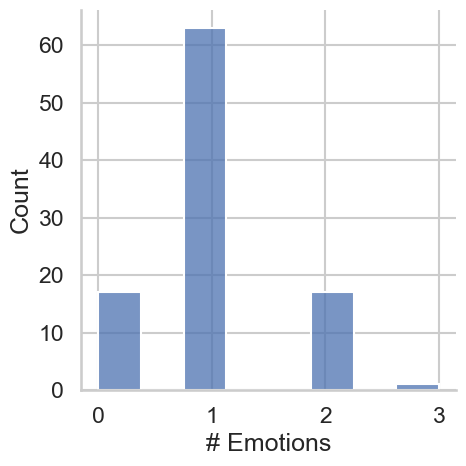

In [5]:
g = sns.displot(
    data=model_pred, 
    x="# Emotions",
)

In [6]:
print(
    "Report with at least one emotion: {:.1f} %".format(
        100*len(model_pred_no_z)/len(model_pred)
    )
)

Report with at least one emotion: 82.7 %


Emotion distribution in reports with at least one emotion

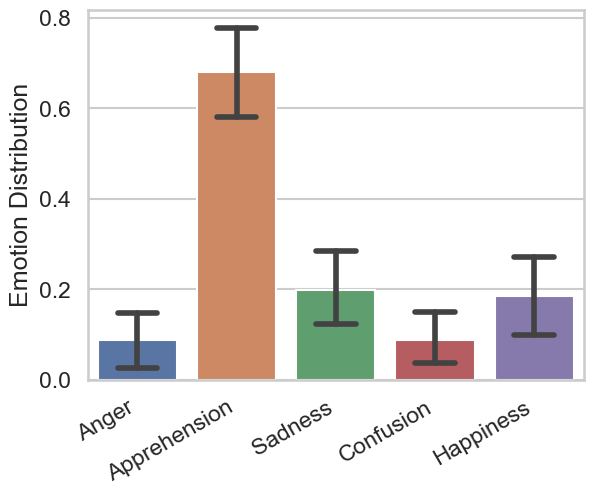

In [7]:
g = sns.barplot(
    data=model_pred_no_z[emotions_list], 
    capsize=.4, 
    linewidth=1.5,
)
g.set(ylabel="Emotion Distribution")
g.set_xticklabels(list(Coding_emotions.values()), rotation=30, horizontalalignment='right')
print()

Unpacking the distribution

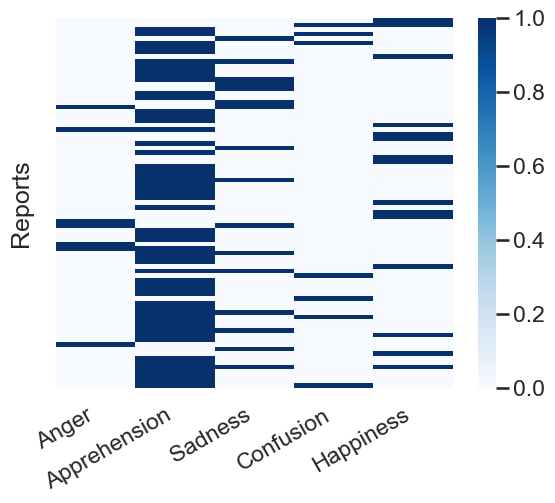

In [8]:
g = sns.heatmap(
    model_pred_no_z[emotions_list].values, 
    cmap="Blues"
)
g.set(ylabel="Reports", yticklabels="")
g.set_xticklabels(list(Coding_emotions.values()), rotation=30, horizontalalignment='right')
print()

Analysis of happiness-labelled dreams

In [9]:
print(
    "Report with at least one emotion, including happiness: {:.1f} %".format(
        100*len(model_pred_no_z[model_pred_no_z["HA"].isin([1])]) / len(model_pred_no_z)
    )
)

Report with at least one emotion, including happiness: 18.5 %


How many of these reports also contain apprehension?

In [10]:
model_pred_no_z[
    model_pred_no_z["HA"].isin([1]) & 
    model_pred_no_z["AP"].isin([1])
]

,AN,AP,SD,CO,HA,# Emotions,report
82,0,1,0,0,1,2,We are walking down a trail. Above and beyond...
92,0,1,1,0,1,3,I am with a friend. We have traveled to a str...


List of the report labelled with happiness

In [11]:
list(model_pred_no_z[model_pred_no_z["HA"].isin([1])]["report"])

[' I am with my old unit in Vietnam. The order comes over the radio that we are now finished with jungle patrols. The Lieutenant makes it official and we silently begin to disband. Suddenly, a civilian, an older man in a suit, emerges from a tent. He speaks to us. " If my son can\'t go, no one goes. " Then he shoots and kills my good friend Jerry B. I am overwhelmed and unload several shots at him. Nothing happens. Then, with an unusually long burst of automatic from my M - 16 I cut him down. As the others have walked off, I throw the gun down and follow after them. There is a feeling of complete freedom. In very high spirits Jim L. and I go to a supermarket and buy food. I am aware that I don\'t wear my steel helmet. The dream is repeated. This time I do the killing with a laser beam. The man is this time Parry, a medic from another company I did not like. He dies a slow and agonizing death.                                                                                               